In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymbar # for MBAR analysis
from pymbar import timeseries # for timeseries analysis

import os, sys
import tables as tb
import mdtraj as md
import scipy.stats as sps

upside_path = '/project/dinner/scguo/upside2'
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

import mdtraj_upside as mu
# import upside_engine as ue

In [2]:
a_dg_file = '/project/dinner/aanto/kaiB/up2/andys_dgs.csv'
a_dgs = np.genfromtxt(a_dg_file, delimiter=',')

a_dg_file1 = '/project/dinner/aanto/kaiB/up2/dgs_al_45.csv'
a_dg_file2 = '/project/dinner/aanto/kaiB/up2/dgs_al_65.csv'
a_ms_file = '/project/dinner/aanto/kaiB/up2/dgs_al_mvalue_new.csv'
a_dgs1 = np.genfromtxt(a_dg_file1, delimiter=',')
a_dgs2 = np.genfromtxt(a_dg_file2, delimiter=',')
a_ms = np.genfromtxt(a_ms_file, delimiter=',')

in_ex2 = a_dgs1[a_dgs1[:,-2]==1,-1]

in_region1 = a_dgs1[:,-2].astype(bool)
in_region2 = a_dgs2[:,-2].astype(bool)
in_region3 = a_ms[:,-2].astype(bool)
a_dgs1_trimmed = a_dgs1[in_region1]
a_dgs2_trimmed = a_dgs2[in_region2]
a_ms_trimmed = a_ms[in_region3]

In [3]:
color_arr = []
alpha_arr = []

for r in np.arange(0,99):
    if r >=9 and r <=14:
        color='red'
    elif r >=21 and r <= 35:
        color='red'
    elif r >=41 and r <=46:
        color='red'
    elif r >= 50 and r <= 56:
        color = 'purple'
    elif r >=64 and r <=69:
        color='orange'
    elif r >=73 and r <=77:
        color='green'
    elif r >=84 and r <=96:
        color='blue' 
    else: 
        color='gray'
    if np.isin(r+1, a_dgs1_trimmed[:,-1]):
        alpha1=1
    else:
        alpha1=0.12
    if np.isin(r+1, a_dgs2_trimmed[:,-1]):
        alpha2=1
    else:
        alpha2=0.12
    if np.isin(r+1, a_ms_trimmed[:,-1]):
        alpha3=1
    else:
        alpha3=0.12
    color_arr.append(color)
    alpha_arr.append([alpha1,alpha2,alpha3])
color_arr = np.asarray(color_arr)
alpha_arr = np.asarray(alpha_arr)

# Load data - For FS (all trans)

In [4]:
pdb_id = 'fs_almut'
start_frame = 2000 # skip first 2000 frames
work_dir = '/project/dinner/scguo/kaiB/test'
n_rep = 48     # replica number
input_dir = "{}/inputs".format(work_dir)
result_dir = "{}/outputs".format(work_dir)

In [8]:
Pot = []
Hb = []
Ts = []
T  = []
PS = []
for i in range(n_rep):
    j=str(i).zfill(2)
    Pot.append(np.load('{}/{}_Energy.npy'.format(result_dir, j))[:,0])  
    Hb.append(np.load('{}/{}_Hbond.npy'.format(result_dir, j))) 
    PS.append( np.load('{}/{}_ps.npy'.format(result_dir, j))) 

    t = np.load('{}/{}_T.npy'.format(result_dir, j))
    nsize = Pot[-1].size
    Ts.append(np.zeros(nsize) + t)
    T.append(t)
    
Pot  = np.array(Pot)
Hb   = np.array(Hb)
Ts   = np.array(Ts)
T    = np.array(T)
PS   = np.array(PS)

# only the residue numbers which have experimental data
res = np.loadtxt('{}/{}.resid'.format(work_dir, pdb_id), dtype=int)
n_res = res.size

print(PS.shape, Pot.shape)

(48, 39997, 91) (48, 39997)


## MBAR reweighting

In [9]:
kB = 1.0 # upside unit
T = np.array(T)
beta = 1 / (kB * T)

cE0 = Pot[:,start_frame:]

FN = cE0[0].size
FNs = np.zeros([n_rep], np.int32) + FN
reducedPot0 = np.zeros([n_rep,n_rep,FN], np.float32)
for k in range(n_rep):
    for l in range(n_rep):
        reducedPot0[k,l] = beta[l] * cE0[k]

In [10]:
mbar0 = pymbar.MBAR(reducedPot0, FNs, verbose=True)

K (total states) = 48, total samples = 1823856
N_k = 
[37997 37997 37997 37997 37997 37997 37997 37997 37997 37997 37997 37997
 37997 37997 37997 37997 37997 37997 37997 37997 37997 37997 37997 37997
 37997 37997 37997 37997 37997 37997 37997 37997 37997 37997 37997 37997
 37997 37997 37997 37997 37997 37997 37997 37997 37997 37997 37997 37997]
There are 48 states with samples.
Initializing free energies to zero.
Initial dimensionless free energies with method zeros
f_k = 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Determining dimensionless free energies by Newton-Raphson / self-consistent iteration.
self consistent iteration gradient norm is 1.5911e+11, Newton-Raphson gradient norm is 1.0209e+11
Choosing self-consistent iteration on iteration 0
self consistent iteration gradient norm is 7.5604e+10, Newton-Raphson gradient norm is 5.2749e+10
Choosing self-consistent iteration for low

## Calculate delta G_HX at different temperatures (melting curves)

In [12]:
dGhx_T = np.zeros((T.size, n_res))
for k in range(T.size):
    t = T[k]
    tt = t / 0.85 * 298. # "real" temperature in K (estimated)
    
    # convert back to unstandardized energies (not in units of kT)
    u_n = (cE0 / (t * kB)).flatten()
    log_w1 = mbar0._computeUnnormalizedLogWeights(u_n)
    # normalize weights
    w1 = np.exp(log_w1)
    w1 /= np.sum(w1)
    
    # use eq. 4.8 in Adam's thesis
    for r in range(n_res):
        pf_i = PS[:,start_frame:,r].flatten()
        mean_pf = np.average(pf_i, weights=w1)
        if mean_pf == 1:
            print(k, r)
            dGhx_T[k, r] = 1000.
        else:
            dGhx_T[k, r] = 0.001987 * tt * np.log((mean_pf/(1.-mean_pf))) # units of kcal/mol

In [13]:
print(dGhx_T.shape)

(48, 91)


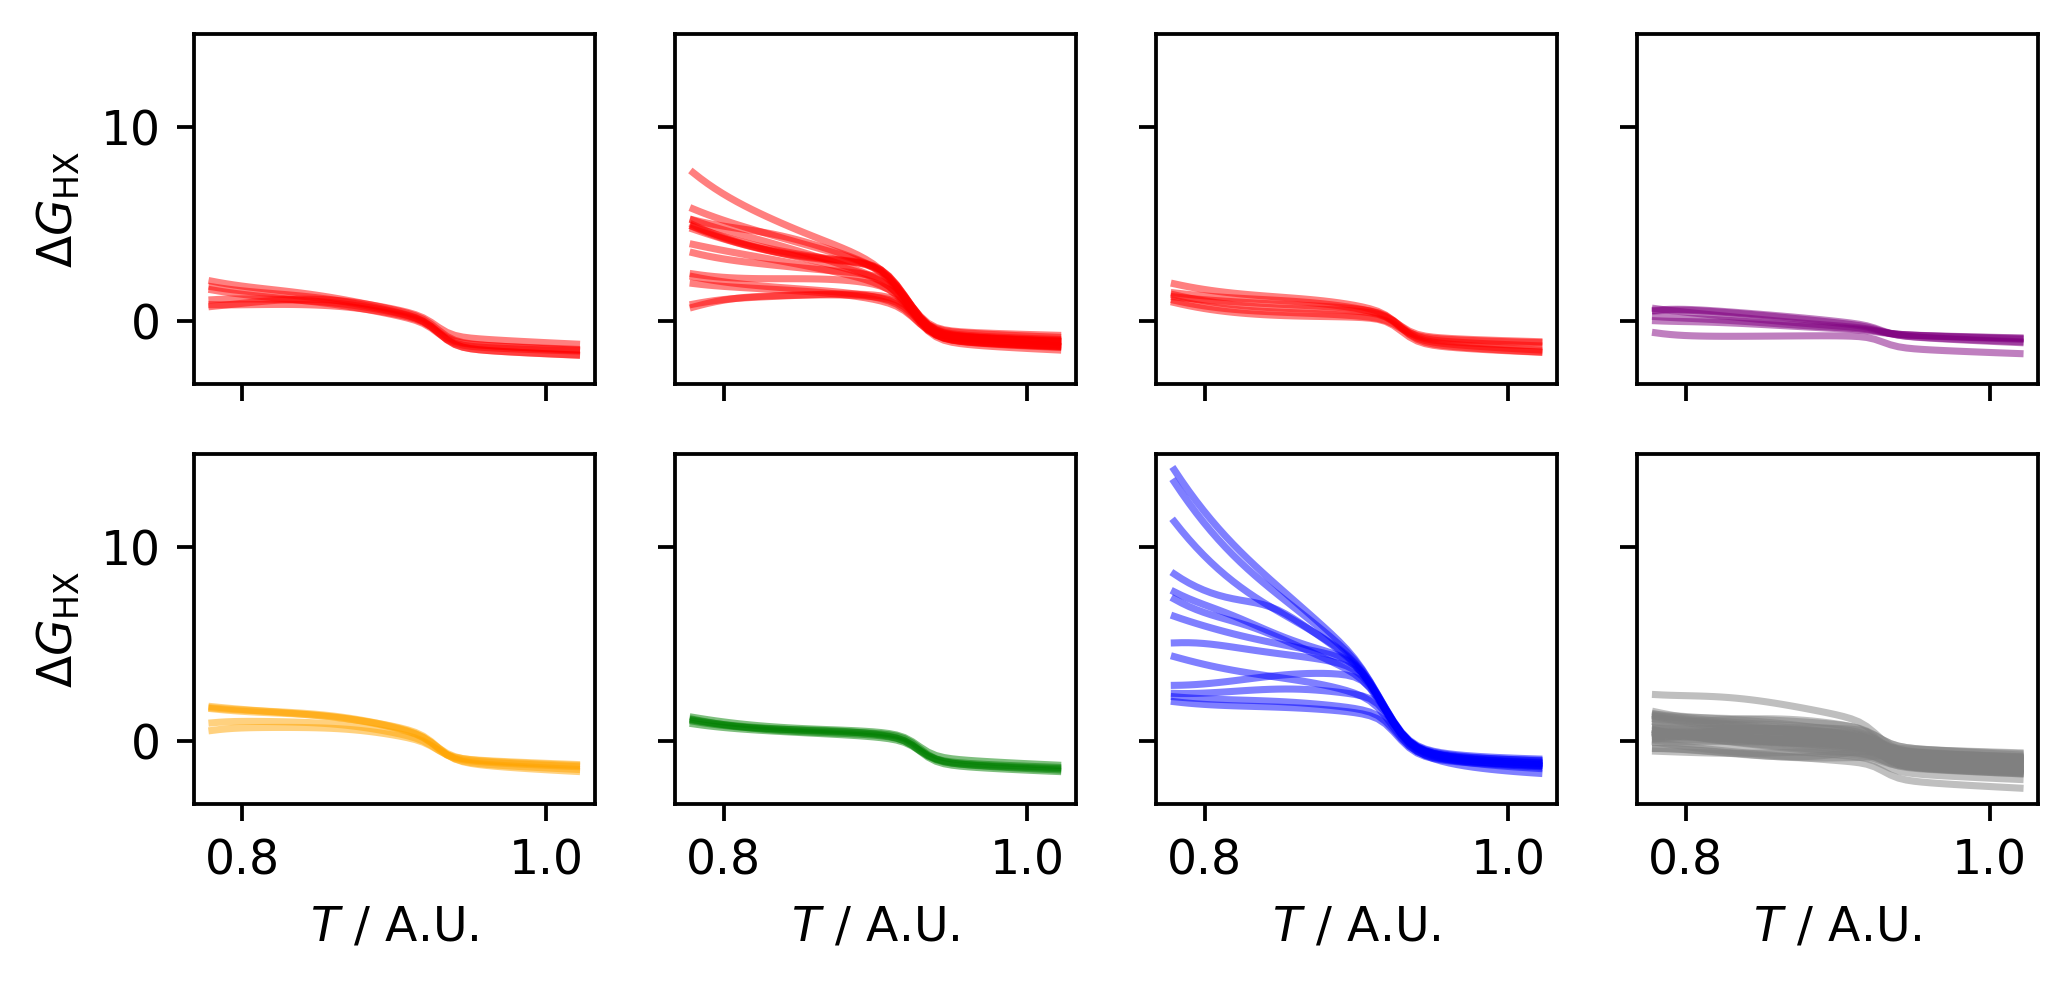

In [14]:
f, ax = plt.subplots(2, 4, figsize=(7,3), dpi=340, sharey=True, sharex=True)

for i,r in enumerate(res):
    if r >=9 and r <=14:
        color='red'
        j, k = 0, 0
    elif r >=21 and r <= 35:
        color='red'
        j, k = 0, 1
    elif r >=41 and r <=46:
        color='red'
        j, k = 0, 2
    elif r >= 50 and r <= 56:
        color = 'purple'
        j, k = 0, 3
    elif r >=64 and r <=69:
        color='orange'
        j, k = 1, 0
    elif r >=73 and r <=77:
        color='green'
        j, k = 1, 1
    elif r >=84 and r <=96:
        color='blue' 
        j, k = 1, 2
    else:
        color = 'gray'
        j, k = 1, 3
    ax[j,k].plot(T, dGhx_T[:,i], color=color, alpha=0.5)

for a in ax.flat:
    a.set_xlabel('$T$ / A.U.')
    a.set_ylabel('$\Delta G_{\mathrm{HX}}$')
    a.label_outer()

# Calculate dG_HX at different denaturant concentrations

In [15]:
T_target = 0.875   # the T you want to use 
m_sens = 0.25  # it is the sensitivity of the denaturant.
                 # a larger value means a lower concentration 
                 # to unfold the protein
                 # 0.05 is a not bad initial guess for urea

# the number of protected residues in evergy frame
pf_frame = np.sum(PS[:, start_frame:, :], axis=2).flatten()

# [den]
den_min = 0.0
den_max = 5
den_bin = 50
den = np.linspace(den_min, den_max, den_bin+1)

# reweight to T_target
TT = T_target / 0.85 * 298
m = m_sens * -pf_frame
u_n = (cE0 / (T_target * kB)).flatten()
log_w1 = mbar0._computeUnnormalizedLogWeights(u_n)
w1 = np.exp(log_w1)
w1 /= np.sum(w1)

# dG at different [den]
dGhx_D = []
for d in den:
    # weight depends on denaturant concentration
    w = np.exp(m * d / T_target) * w1
    w /= np.sum(w)
    
    probp = np.zeros(n_res)
    for j in range(n_res):
        pf_i = PS[:, start_frame:, j].flatten()
        probp[j] = np.sum(pf_i * w)
    dGhx_D.append(TT * np.log(probp / (1. - probp)) * 0.001987)
dGhx_D = np.array(dGhx_D)

# m-value: initial the slope of dG vs [den]
mValue = np.diff(dGhx_D, axis=0) / (den[0] - den[1])

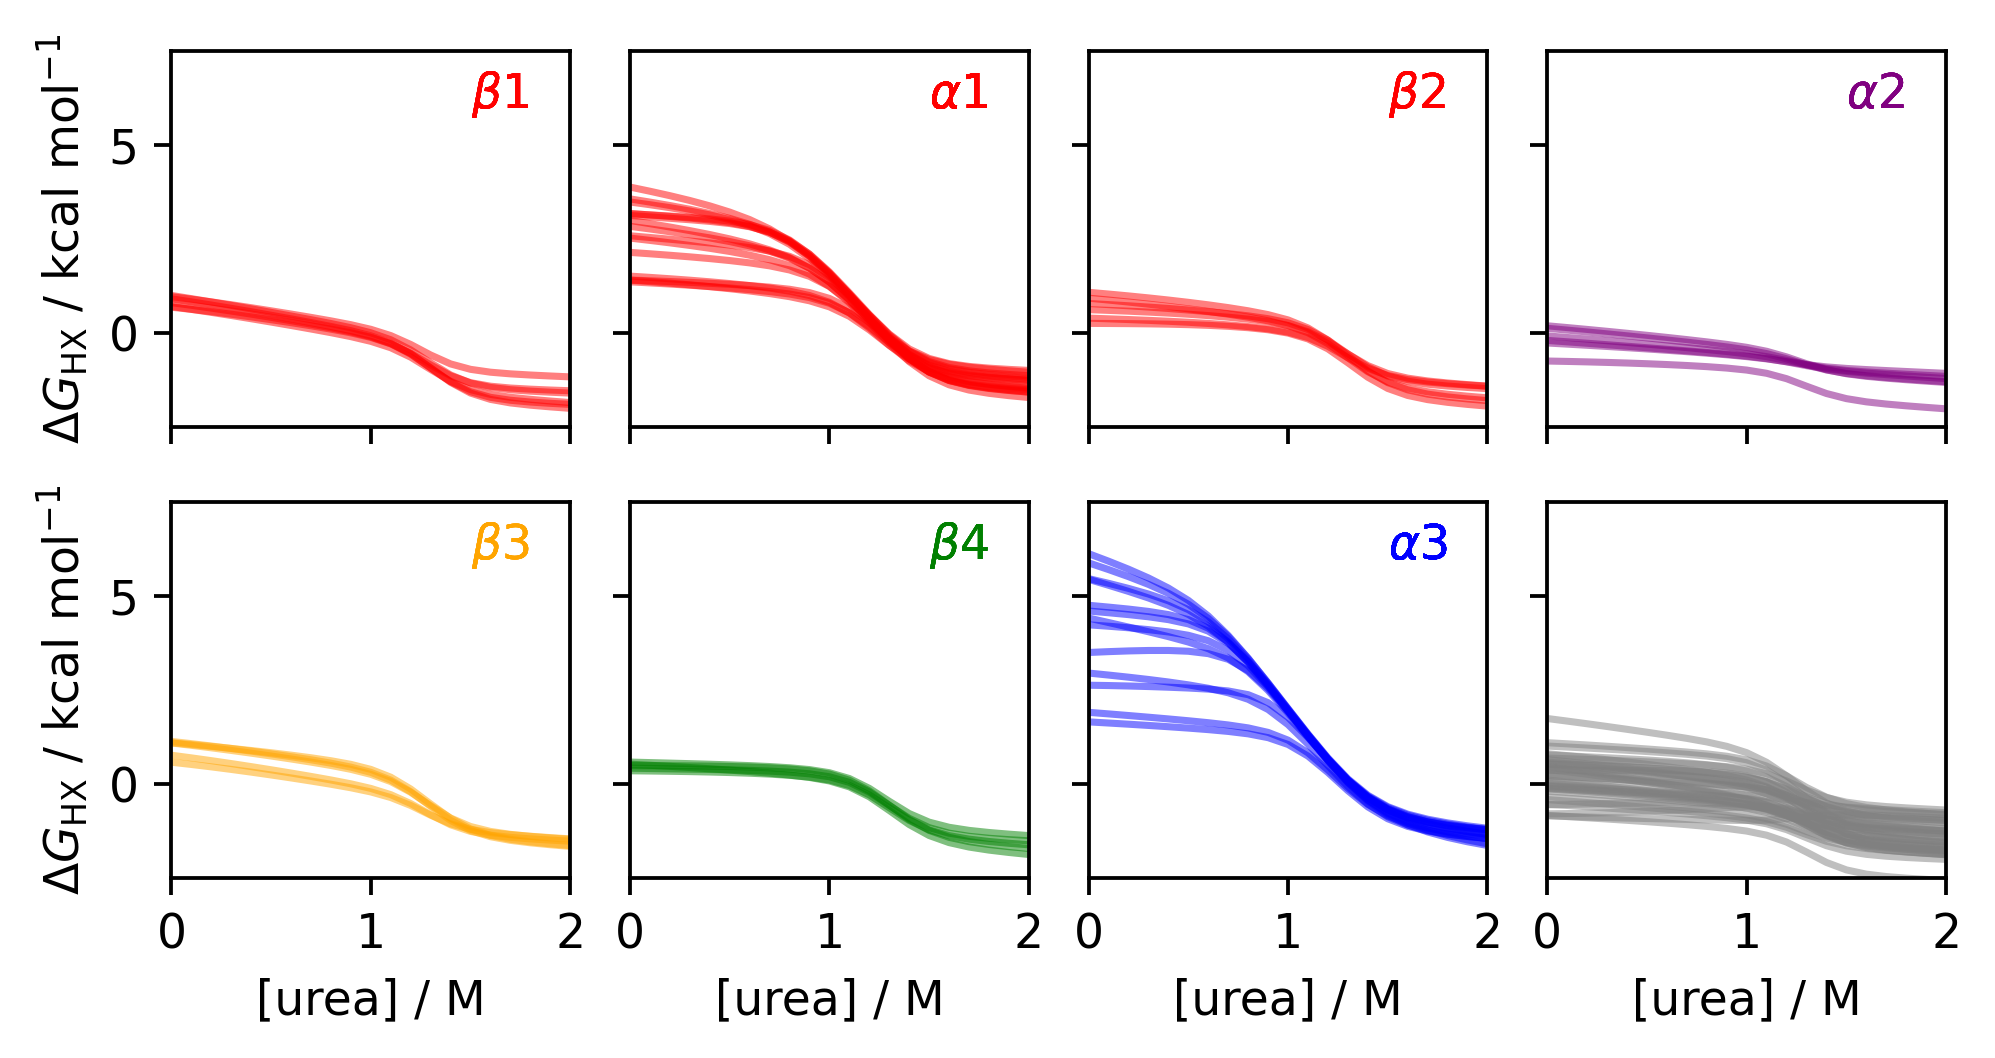

In [16]:
f, ax = plt.subplots(2, 4, figsize=(6,3), dpi=340, sharey=True, sharex=True, constrained_layout=True)
for i,r in enumerate(res):
    if r >=9 and r <=14:
        color='red'
        text = r'$\beta 1$'
        j, k = 0, 0
    elif r >=21 and r <= 35:
        color='red'
        text = r'$\alpha 1$'
        j, k = 0, 1
    elif r >=41 and r <=46:
        color='red'
        text = r'$\beta 2$'
        j, k = 0, 2
    elif r >= 50 and r <= 56:
        color = 'purple'
        text = r'$\alpha 2$'
        j, k = 0, 3
    elif r >=64 and r <=69:
        color='orange'
        text = r'$\beta 3$'
        j, k = 1, 0
    elif r >=73 and r <=77:
        color='green'
        text = r'$\beta 4$'
        j, k = 1, 1
    elif r >=84 and r <=96:
        color='blue' 
        text = r'$\alpha 3$'
        j, k = 1, 2
    else:
        text=''
        color = 'gray'
        j, k = 1, 3
    ax[j,k].plot(den, dGhx_D[:,i], color=color, alpha=0.5)
    ax[j,k].text(1.5, 6, text, color=color)

ax[0,0].set_xlim([0, 2])
ax[0,0].set_ylim([-2.5, 7.5])
for a in ax.flat:
    a.set_xlabel('[urea] / M')
    a.set_ylabel('$\Delta G_{\mathrm{HX}}$ / kcal mol$^{-1}$')
    a.label_outer()

In [18]:
mValue.shape

(50, 91)